### 在20180503_04LightGBM_addTfIdfFeatures的基础上新增按某些分类变量统计的价格均值、方差、中位数等特征

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from string import punctuation as en_punctuation
import re
from nltk.corpus import stopwords
# import graphviz
import os
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn.externals import joblib
from tqdm import tqdm
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

/usr/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
current_dir = r'/home/yw/study/Competition/Avito-Demand-Prediction-Challenge'
data_dirs = dict()
data_dirs['train_data'] = os.path.join(current_dir, 'data/train.csv')
data_dirs['test_data'] = os.path.join(current_dir, 'data/test.csv')
data_dirs['periods_train'] = os.path.join(current_dir, 'data/periods_train.csv')
data_dirs['periods_test'] = os.path.join(current_dir, 'data/periods_test.csv')
data_dirs['train_active'] = os.path.join(current_dir, 'data/train_active.csv')
data_dirs['test_active'] = os.path.join(current_dir, 'data/test_active')
data_dirs['pred_result'] = os.path.join(current_dir, 'data/submits/20180504_05LightGBM_addAggFeatures.csv')
data_dirs['model_path'] = os.path.join(current_dir, 'data/model_data/20180504_05LightGBM_addAggFeatures.pkl')
data_dirs['train_feature_path'] = os.path.join(current_dir, 'data/features/20180504_05LightGBM_addAggFeatures/train.csv')
data_dirs['test_feature_path'] = os.path.join(current_dir, 'data/features/20180504_05LightGBM_addAggFeatures/test.csv')

### a 特征提取

In [9]:
def filter_text(text, filters=None, lower=True):
    """
    对文本进行过滤
    :param text: 需要过滤处理的文本
    :param filters: 需要过滤掉的字符集
    :param lower: 是否忽略英文字符的大小写
    :return: 过滤后的文本
    """
    if lower:
        text = text.lower()
    if filters is None:
        filters = en_punctuation+r'\t\r\n\f\v'
    sub_parttern = '['+filters+']'
    text = re.sub(sub_parttern, ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def load_text_data(data_path, train=False, text_columns=None):
    if text_columns is None:
        text_columns = ['title', 'description']
    column_len = len(text_columns)
    if train:
        texts = pd.read_csv(data_path, usecols=text_columns + ['deal_probability'])
        targets = texts['deal_probability'].values
        texts = texts[text_columns].apply(lambda x: ' '.join([('' if x[i] is np.nan else str(x[i])) for i in range(column_len)]), axis=1)
        texts = texts.apply(filter_text)
        return texts, targets
    else:
        texts = pd.read_csv(data_path, usecols=text_columns + ['item_id'])
        pred_items = texts[['item_id']]
        texts = texts[text_columns].apply(
            lambda x: ' '.join([('' if x[i] is np.nan else str(x[i])) for i in range(column_len)]), axis=1)
        texts = texts.apply(filter_text)
        return texts, pred_items

def get_tfidf(data_path, tfidf_transformer=None, train=False, text_columns=None):
    if text_columns is None:
        text_columns = ['title', 'description']
    print('get_tfidf:loading raw text data...')
    texts, targets = load_text_data(data_path, train=train, text_columns=text_columns)
    if train:
        print('get_tfidf:training TfidfVectorizer...')
        stop_words = list(stopwords.words('russian')) + list(stopwords.words('english'))
        tfidf_transformer = TfidfVectorizer(binary=False, norm='l2', stop_words=stop_words, max_features=200000)
        tfidf_transformer = tfidf_transformer.fit(texts)
    tfidf = tfidf_transformer.transform(texts)
    return tfidf, targets, tfidf_transformer

def word_count(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text.split()) 
    
def count_chars(raw_text):
    if type(raw_text) == float:
        return 0
    return len(raw_text)

def prepare_data(data_dirs):
    train_df = pd.read_csv(data_dirs['train_data'], parse_dates=["activation_date"])
    test_df = pd.read_csv(data_dirs['test_data'], parse_dates=["activation_date"])
    
    use_features = set()

    train_y = train_df["deal_probability"].values
    test_id = test_df["item_id"].values
    # explore features
    # [1]weekday
    train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
    test_df["activation_weekday"] = test_df["activation_date"].dt.weekday
    # [2]monthday
    train_df["activation_monthday"] = train_df["activation_date"].dt.day
    test_df["activation_monthday"] = test_df["activation_date"].dt.day
    
    use_features.update(['activation_weekday','activation_monthday'])
    
    text_columns=['param_1','param_2','param_3','title','description']+['parent_category_name','category_name']
    for feat_name in text_columns:
        # [4]char length
        feat_len = feat_name+"_len"
        train_df[feat_len] = train_df[feat_name].apply(count_chars)
        test_df[feat_len] = test_df[feat_name].apply(count_chars)
        # [5]word count
        feat_w_count = feat_name+"_w_count"
        train_df[feat_w_count] = train_df[feat_name].apply(word_count)
        test_df[feat_w_count] = test_df[feat_name].apply(word_count)
        
        use_features.update([feat_len, feat_w_count])
    
    # [6]images length
    train_df['image_exists'] = train_df['image'].isnull().astype(int)
    test_df['image_exists'] = test_df['image'].isnull().astype(int)
    
    use_features.add('image_exists')
    
    
    # [7]Label encode the categorical variables #
    print('[5] Encoding the categorical features...')
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    for col in tqdm(cat_vars):
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
    use_features.update(cat_vars)
    
    use_features.update(['price', 'item_seq_number', 'image_top_1'])
    
    print('[8] Statistic deal_probability agg features...')
    for c in tqdm(cat_vars+['activation_weekday','activation_monthday','image_top_1']):
        gp = train_df.groupby(c)['deal_probability']
        mean = gp.mean()
        std  = gp.std()
        med = gp.median()
        mean_feat = c + '_deal_probability_avg'
        std_feat = c + '_deal_probability_std'
        med_feat = c + '_deal_probability_median'
        
        use_features.update([mean_feat,std_feat,med_feat])
        
        train_df[mean_feat] = train_df[c].map(mean)
        train_df[std_feat] = train_df[c].map(std)
        train_df[med_feat] = train_df[c].map(med)
        
        test_df[mean_feat] = test_df[c].map(mean)
        test_df[std_feat] = test_df[c].map(std)
        test_df[med_feat] = test_df[c].map(med)
    
    print('[9] statistic price agg features...')
    for c in tqdm(cat_vars+['activation_weekday','activation_monthday','image_top_1']):
        gp = train_df.groupby(c)['price']
        mean = gp.mean()
        std  = gp.std()
        med = gp.median()
        mean_feat = c + '_price_avg'
        std_feat = c + '_price_std'
        med_feat = c + '_price_median'
        
        use_features.update([mean_feat,std_feat,med_feat])
        
        train_df[mean_feat] = train_df[c].map(mean)
        train_df[std_feat] = train_df[c].map(std)
        train_df[med_feat] = train_df[c].map(med)
        
        test_df[mean_feat] = test_df[c].map(mean)
        test_df[std_feat] = test_df[c].map(std)
        test_df[med_feat] = test_df[c].map(med)
    
    use_features=list(use_features)
    train_X = train_df[use_features]
    test_X = test_df[use_features]
    return train_X, train_y, test_X, test_id, cat_vars+['activation_weekday','activation_monthday']

In [5]:
def get_svd_feature(data_dirs, text_columns, n_comp=10):
    print('[1] Converting train texts to TF-IDF vectors...')
    x_train_tfidf, targets, tfidf_transformer = get_tfidf(data_dirs['train_data'],
                                                          tfidf_transformer=None,
                                                          train=True,
                                                          text_columns=text_columns)
    print('[2] Converting test texts to TF-IDF vectors...')
    x_test_tfidf, _, _ = get_tfidf(data_dirs['test_data'],
                                   tfidf_transformer=tfidf_transformer,
                                   train=False,
                                   text_columns=text_columns)
    print('[3] Training SVD transoformer...')
    trunc_svd = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    trunc_svd.fit(x_train_tfidf)
    print('[4] Decomposition...')
    train_svd = pd.DataFrame(trunc_svd.transform(x_train_tfidf))
    test_svd = pd.DataFrame(trunc_svd.transform(x_test_tfidf))
    train_svd.columns = ['svd_'+str(i+1) for i in range(n_comp)]
    test_svd.columns = ['svd_'+str(i+1) for i in range(n_comp)]
    
    return train_svd, test_svd

In [6]:
def combine_all_feature(data_dirs):
    text_columns = ['title', 'description']+['param_1', 'param_2', 'param_3', 'parent_category_name', 'category_name']
    n_comp = 10
    train_svd, test_svd = get_svd_feature(data_dirs, text_columns=text_columns, n_comp=n_comp)
    
    train_X, train_y, test_X, test_id, cat_vars= prepare_data(data_dirs)
    
    train_X = pd.concat([train_X, train_svd], axis=1)
    test_X = pd.concat([test_X, test_svd], axis=1)
    return train_X, train_y, test_X, test_id, cat_vars

In [7]:
train_X, train_y, test_X, test_id, cat_vars= combine_all_feature(data_dirs)

[1] Converting train texts to TF-IDF vectors...
get_tfidf:loading raw text data...
get_tfidf:training TfidfVectorizer...
[2] Converting test texts to TF-IDF vectors...
get_tfidf:loading raw text data...
[3] Training SVD transoformer...
[4] Decomposition...


100%|██████████| 11/11 [00:08<00:00,  1.05it/s]


In [8]:
train_X.head(3)

,price,region_deal_probability_std,activation_monthday_deal_probability_median,image_top_1_price_median,param_1_deal_probability_median,city_deal_probability_avg,image_top_1_deal_probability_std,image_top_1_deal_probability_median,city_price_std,param_2,...,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10
0,400.0,0.252559,0.0,1200.0,0.0,0.123397,0.220444,0.0,8.629175e+05,112,...,0.041671,-0.040757,0.050099,0.178052,0.011905,-0.061201,-0.011576,0.028543,0.005648,-0.013546
1,3000.0,0.259018,0.0,4000.0,0.0,0.139400,0.292832,0.0,2.753272e+06,112,...,0.011289,-0.028031,0.090803,0.014687,0.003909,0.157237,-0.114391,0.000993,-0.000381,-0.025389
2,4000.0,0.254793,0.0,4990.0,0.0,0.124881,0.297891,0.0,2.552933e+06,112,...,0.016017,-0.020259,0.056241,0.034212,-0.002227,0.080857,0.149096,-0.026116,-0.004038,-0.011544


In [14]:
train_X.to_csv(data_dirs['train_feature_path'],index=False)
test_X.to_csv(data_dirs['test_feature_path'],index=False)

In [15]:
X_train,X_val,y_train,y_val=train_test_split(train_X,train_y,test_size=0.20,random_state=9)

# 1 Base line

In [16]:
def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=5000,folds=folds,nfold=cv_folds,stratified=False,
                        metrics='rmse',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['rmse-mean']))
        print('Best Iteration:',len(cvresult['rmse-mean']))
        
    alg.fit(X,y,eval_metric='rmse',feature_name=feature_names,categorical_feature=cat_features,
            eval_set=[(X,y),(X_test, y_test)],eval_names=['train','val'],verbose=20)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y,dtrain_predictions))))
    print('Model report on test:')
    print('Test RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test,dtest_predictions))))
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    lgb.plot_metric(lgbr)
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='rmse',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='rmse',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

In [17]:
params={'boosting_type': 'gbdt',
        'colsample_bytree': 0.8,
       'learning_rate': 0.2,
       'max_bin': 168,
       'max_depth': 9,
       'min_child_samples': 30,
       'min_child_weight': 5,
       'min_split_gain': 1,
       'n_estimators': 200,
       'n_jobs': -1,
       'num_leaves': 60,
       'objective': 'regression',
       'random_state': 9,
       'reg_alpha': 0,
       'reg_lambda': 0,
       'subsample': 0.9,
       'subsample_freq': 1
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':9,
        'learning_rate':0.2,
        'max_bin':168,
        'objective':'regression',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.9,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':-1,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [18]:
lgbr=lgb.LGBMRegressor(**params)

[20]	cv_agg's rmse: 0.226272 + 0.000172758
[40]	cv_agg's rmse: 0.225137 + 0.000205103
[60]	cv_agg's rmse: 0.225005 + 0.000196048
[80]	cv_agg's rmse: 0.225003 + 0.000197642
Best Iteration: 62


/usr/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['activation_monthday', 'activation_weekday', 'category_name', 'city', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	train's rmse: 0.223228	val's rmse: 0.226227
[40]	train's rmse: 0.220147	val's rmse: 0.224991
[60]	train's rmse: 0.219507	val's rmse: 0.224783
Model report on trian:
Train RMSE:0.2195
Model report on test:
Test RMSE:0.2248


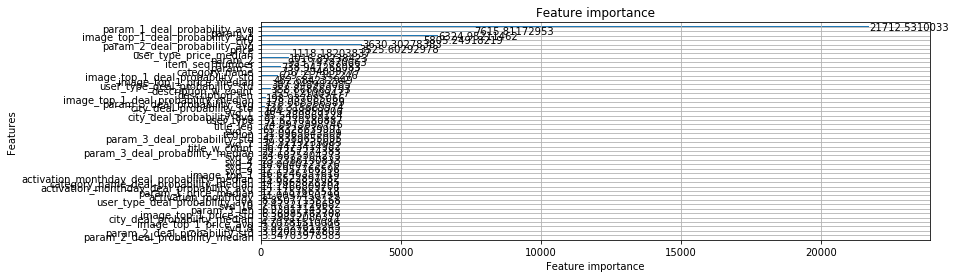

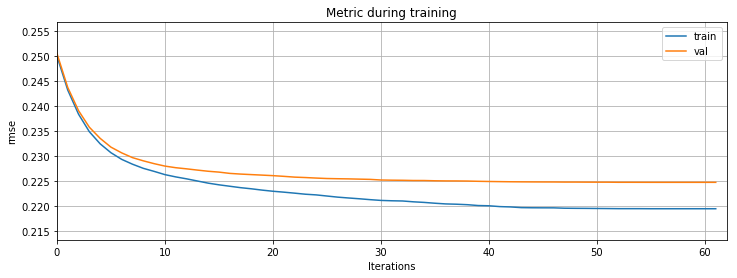

In [19]:
get_lgb_params(lgbr.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [22]:
params['n_estimators']=62

# 2 Tune params

In [23]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

In [24]:
def rmse(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))
scorer = metrics.make_scorer(rmse, greater_is_better=False)

## 2.1 num_leaves

In [25]:
searchParam={'num_leaves':(145,148,149,150,151,155)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 155
Best score: -0.22477008545
     mean_test_score  mean_train_score  std_test_score  std_train_score
145        -0.224846         -0.216990        0.000743         0.000220
148        -0.224860         -0.216905        0.000803         0.000201
149        -0.224811         -0.216917        0.000808         0.000197
150        -0.224814         -0.216864        0.000779         0.000277
151        -0.224864         -0.216958        0.000770         0.000232
155        -0.224770         -0.216779        0.000769         0.000186


In [26]:
searchParam={'num_leaves':(154,155,160,165,170)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 170
Best score: -0.224764607349
     mean_test_score  mean_train_score  std_test_score  std_train_score
154        -0.224829         -0.216673        0.000818         0.000341
155        -0.224770         -0.216779        0.000769         0.000186
160        -0.224783         -0.216882        0.000851         0.000071
165        -0.224819         -0.216690        0.000848         0.000169
170        -0.224765         -0.216622        0.000783         0.000257


In [27]:
searchParam={'num_leaves':(170,175,180,185,190)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 170
Best score: -0.224764607349
     mean_test_score  mean_train_score  std_test_score  std_train_score
170        -0.224765         -0.216622        0.000783         0.000257
175        -0.224808         -0.216493        0.000829         0.000161
180        -0.224789         -0.216497        0.000808         0.000431
185        -0.224823         -0.216585        0.000831         0.000203
190        -0.224845         -0.216399        0.000807         0.000146


## 2.2 max_depth

In [28]:
searchParam={'max_depth':[10,15,20,25,28]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 15
Best score: -0.224722704557
    mean_test_score  mean_train_score  std_test_score  std_train_score
10        -0.224741         -0.216278        0.000825         0.000305
15        -0.224723         -0.216147        0.000788         0.000191
20        -0.224752         -0.216184        0.000788         0.000218
25        -0.224750         -0.216230        0.000790         0.000252
28        -0.224750         -0.216230        0.000790         0.000252


In [29]:
searchParam={'max_depth':[14,15,16,17,18]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 14
Best score: -0.224718842688
    mean_test_score  mean_train_score  std_test_score  std_train_score
14        -0.224719         -0.216160        0.000805         0.000231
15        -0.224723         -0.216147        0.000788         0.000191
16        -0.224749         -0.216130        0.000818         0.000241
17        -0.224747         -0.216223        0.000769         0.000198
18        -0.224748         -0.216160        0.000795         0.000198


In [30]:
searchParam={'max_depth':[8,9,10,11,12,13,14]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 11
Best score: -0.224707839308
    mean_test_score  mean_train_score  std_test_score  std_train_score
8         -0.224935         -0.217302        0.000836         0.000156
9         -0.224765         -0.216622        0.000783         0.000257
10        -0.224741         -0.216278        0.000825         0.000305
11        -0.224708         -0.216231        0.000772         0.000325
12        -0.224713         -0.216176        0.000840         0.000368
13        -0.224758         -0.216154        0.000828         0.000236
14        -0.224719         -0.216160        0.000805         0.000231


## 2.3 subsample

In [31]:
searchParam={'subsample':[0.6,0.7,0.8,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 1.0
Best score: -0.224580919187
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.6        -0.225290         -0.217798        0.000819         0.000182
0.7        -0.224989         -0.217064        0.000796         0.000213
0.8        -0.224845         -0.216252        0.000840         0.000260
0.9        -0.224708         -0.216231        0.000772         0.000325
1.0        -0.224581         -0.217144        0.000823         0.000194


## 2.4 subsample_freq

In [32]:
#searchParam={'subsample_freq':[1,2,3,4,5,6,7,8]}
#turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

## 2.5 colsample_bytree

In [33]:
searchParam={'colsample_bytree':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.6
Best score: -0.224449887594
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.60        -0.224450         -0.218370        0.000791         0.000252
0.70        -0.224450         -0.217609        0.000865         0.000332
0.75        -0.224618         -0.217284        0.000775         0.000149
0.80        -0.224581         -0.217144        0.000823         0.000194
0.85        -0.224761         -0.216211        0.000777         0.000180
0.90        -0.224950         -0.215470        0.000743         0.000179
0.95        -0.224975         -0.215224        0.000822         0.000214
1.00        -0.225112         -0.215030        0.000773         0.000132


In [36]:
searchParam={'colsample_bytree':[0.56,0.58,0.6,0.62,0.64]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.58
Best score: -0.224401678468
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.56        -0.224481         -0.218481        0.000823         0.000151
0.58        -0.224402         -0.218456        0.000805         0.000135
0.60        -0.224450         -0.218370        0.000791         0.000252
0.62        -0.224460         -0.218133        0.000837         0.000228
0.64        -0.224478         -0.218017        0.000823         0.000281


## 2.6 reg_alpha

In [37]:
searchParam={'reg_alpha':[0,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_alpha : 0
Best score: -0.224401678468
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.224402         -0.218456        0.000805         0.000135
0.00001         -0.224402         -0.218456        0.000805         0.000135
0.00005         -0.224402         -0.218456        0.000805         0.000135
0.00010         -0.224402         -0.218456        0.000805         0.000135
0.00050         -0.224403         -0.218449        0.000795         0.000170
0.00100         -0.224415         -0.218424        0.000788         0.000198
0.00500         -0.224441         -0.218378        0.000801         0.000183
0.01000         -0.224408         -0.218422        0.000797         0.000168
0.05000         -0.224415         -0.218350        0.000852         0.000227
0.10000         -0.224429         -0.218433        0.000818         0.000283
0.50000         -0.224521         -0.218372        0.000841         0.000273
1.00000         -0.22

## 2.7 reg_lambda

In [38]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,0.9,1,1.1,1.5,2,5]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 0.001
Best score: -0.224401678456
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000        -0.224402         -0.218456        0.000805         0.000135
0.00001        -0.224402         -0.218456        0.000805         0.000135
0.00100        -0.224402         -0.218456        0.000805         0.000135
0.10000        -0.224454         -0.218371        0.000806         0.000277
0.50000        -0.224478         -0.218466        0.000846         0.000278
0.90000        -0.224511         -0.218353        0.000796         0.000259
1.00000        -0.224516         -0.218436        0.000811         0.000172
1.10000        -0.224425         -0.218461        0.000805         0.000194
1.50000        -0.224502         -0.218464        0.000842         0.000142
2.00000        -0.224479         -0.218471        0.000827         0.000247
5.00000        -0.224465         -0.218407        0.000815         0.000135


## 2.8 min_child_samples

In [39]:
searchParam={'min_child_samples':[10,20,30,40,50]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 30
Best score: -0.224401678456
    mean_test_score  mean_train_score  std_test_score  std_train_score
10        -0.224407         -0.218413        0.000812         0.000172
20        -0.224472         -0.218426        0.000789         0.000197
30        -0.224402         -0.218456        0.000805         0.000135
40        -0.224500         -0.218356        0.000833         0.000240
50        -0.224505         -0.218516        0.000854         0.000241


In [40]:
searchParam={'min_child_samples':[25,28,30,32,35]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 30
Best score: -0.224401678456
    mean_test_score  mean_train_score  std_test_score  std_train_score
25        -0.224459         -0.218408        0.000843         0.000227
28        -0.224480         -0.218350        0.000833         0.000219
30        -0.224402         -0.218456        0.000805         0.000135
32        -0.224433         -0.218440        0.000788         0.000203
35        -0.224452         -0.218390        0.000812         0.000226


## 2.9 min_child_weight

In [41]:
#searchParam={'min_child_weight':[1e-5,2e-5,3e-5,5e-5,1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1,0.5,1.0,3.0,5.0]}
#turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

## 2.10 max_bin

In [43]:
searchParam={'max_bin':[158,168,178]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_bin : 168
Best score: -0.224401678456
     mean_test_score  mean_train_score  std_test_score  std_train_score
158        -0.224464         -0.218434        0.000836         0.000108
168        -0.224402         -0.218456        0.000805         0.000135
178        -0.224468         -0.218359        0.000810         0.000184


## 2.11 min_split_gain

In [44]:
searchParam={'min_split_gain':[0.05,0.17,0.18,0.19,0.5,]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.19
Best score: -0.223567379195
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.05        -0.223590         -0.210843        0.000779         0.000111
0.17        -0.223623         -0.211380        0.000807         0.000281
0.18        -0.223596         -0.211671        0.000778         0.000179
0.19        -0.223567         -0.211737        0.000769         0.000181
0.50        -0.223993         -0.216288        0.000813         0.000149


In [45]:
searchParam={'min_split_gain':[0.185,0.189,0.19,0.191,0.195]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.195
Best score: -0.223557678844
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.185        -0.223598         -0.211609        0.000826         0.000309
0.189        -0.223603         -0.211570        0.000796         0.000241
0.190        -0.223567         -0.211737        0.000769         0.000181
0.191        -0.223595         -0.211814        0.000833         0.000213
0.195        -0.223558         -0.211820        0.000790         0.000143


In [46]:
searchParam={'min_split_gain':[0.194,0.195,0.2,0.25,0.3]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_split_gain : 0.2
Best score: -0.223500725138
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.194        -0.223539         -0.211907        0.000813         0.000086
0.195        -0.223558         -0.211820        0.000790         0.000143
0.200        -0.223501         -0.212060        0.000815         0.000324
0.250        -0.223630         -0.213217        0.000742         0.000159
0.300        -0.223651         -0.213980        0.000799         0.000155


## 2.12 lower learning_rate

[20]	cv_agg's rmse: 0.250567 + 0.000230917
[40]	cv_agg's rmse: 0.24378 + 0.000203766
[60]	cv_agg's rmse: 0.239129 + 0.000183452
[80]	cv_agg's rmse: 0.235645 + 0.000181706
[100]	cv_agg's rmse: 0.233148 + 0.00017824
[120]	cv_agg's rmse: 0.231257 + 0.000179535
[140]	cv_agg's rmse: 0.229909 + 0.000178471
[160]	cv_agg's rmse: 0.228857 + 0.000178028
[180]	cv_agg's rmse: 0.227964 + 0.00018602
[200]	cv_agg's rmse: 0.22739 + 0.000190705
[220]	cv_agg's rmse: 0.226893 + 0.000194462
[240]	cv_agg's rmse: 0.226488 + 0.000192971
[260]	cv_agg's rmse: 0.226165 + 0.000194588
[280]	cv_agg's rmse: 0.22583 + 0.000196513
[300]	cv_agg's rmse: 0.225578 + 0.000199481
[320]	cv_agg's rmse: 0.225324 + 0.000199132
[340]	cv_agg's rmse: 0.225123 + 0.000201472
[360]	cv_agg's rmse: 0.224971 + 0.000205154
[380]	cv_agg's rmse: 0.224793 + 0.000203936
[400]	cv_agg's rmse: 0.224611 + 0.000205633
[420]	cv_agg's rmse: 0.224473 + 0.000205676
[440]	cv_agg's rmse: 0.224358 + 0.000206021
[460]	cv_agg's rmse: 0.224228 + 0.0002096

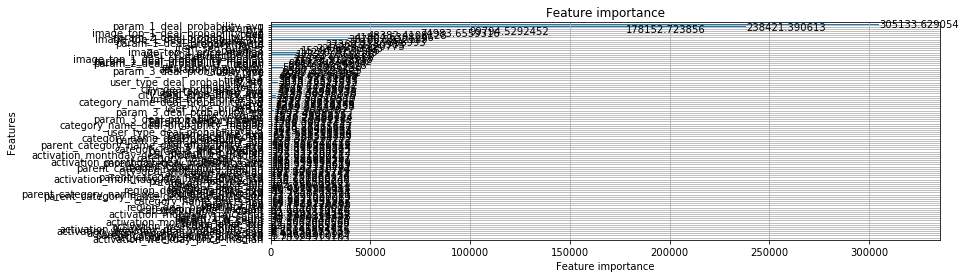

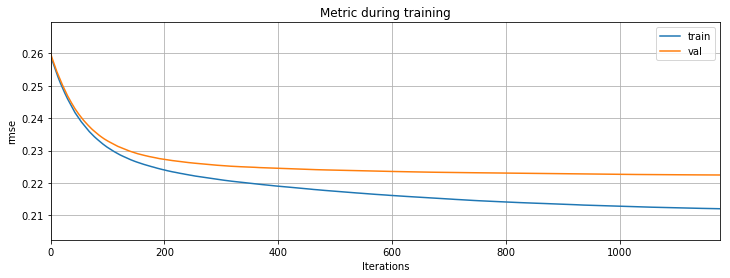

In [47]:
params['learning_rate']=0.01
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.232911 + 0.000187276
[40]	cv_agg's rmse: 0.2272 + 0.000180414
[60]	cv_agg's rmse: 0.225798 + 0.000180617
[80]	cv_agg's rmse: 0.224859 + 0.000197543
[100]	cv_agg's rmse: 0.224274 + 0.000201912
[120]	cv_agg's rmse: 0.223837 + 0.000209766
[140]	cv_agg's rmse: 0.223611 + 0.000219991
[160]	cv_agg's rmse: 0.223369 + 0.000229427
[180]	cv_agg's rmse: 0.223141 + 0.000233418
[200]	cv_agg's rmse: 0.22303 + 0.00023476
[220]	cv_agg's rmse: 0.222914 + 0.000233939
[240]	cv_agg's rmse: 0.222852 + 0.000242906
[260]	cv_agg's rmse: 0.222841 + 0.00024034
[280]	cv_agg's rmse: 0.22284 + 0.000240044
[300]	cv_agg's rmse: 0.22284 + 0.000240044
Best Iteration: 273
[20]	train's rmse: 0.230756	val's rmse: 0.232779
[40]	train's rmse: 0.223998	val's rmse: 0.227093
[60]	train's rmse: 0.221201	val's rmse: 0.225335
[80]	train's rmse: 0.219244	val's rmse: 0.224468
[100]	train's rmse: 0.217784	val's rmse: 0.223971
[120]	train's rmse: 0.216483	val's rmse: 0.22361
[140]	train's rmse: 0.215533	val's r

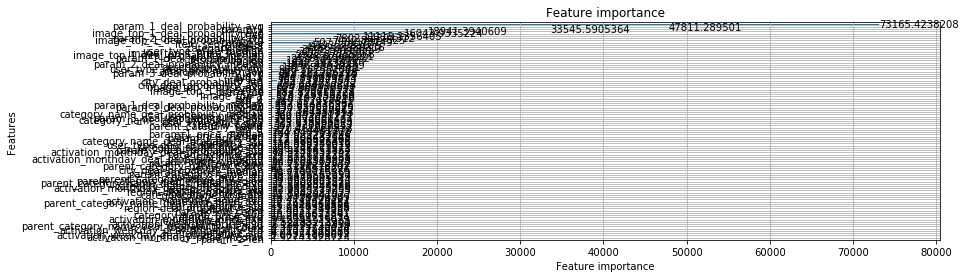

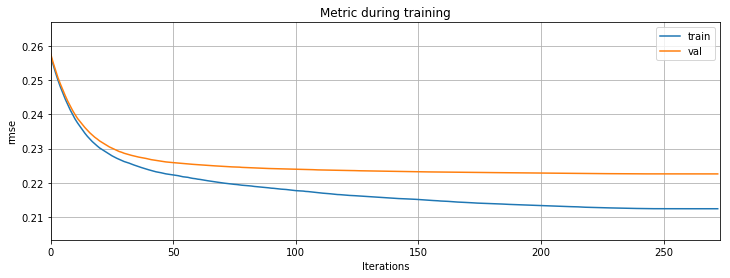

In [48]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.228705 + 0.000189492
[40]	cv_agg's rmse: 0.225251 + 0.000215591
[60]	cv_agg's rmse: 0.224492 + 0.000217861
[80]	cv_agg's rmse: 0.223882 + 0.000228359
[100]	cv_agg's rmse: 0.223521 + 0.000232941
[120]	cv_agg's rmse: 0.223236 + 0.000246362
[140]	cv_agg's rmse: 0.223041 + 0.000253033
[160]	cv_agg's rmse: 0.22296 + 0.000252288
[180]	cv_agg's rmse: 0.222958 + 0.000253203
Best Iteration: 167
[20]	train's rmse: 0.225789	val's rmse: 0.228601
[40]	train's rmse: 0.220677	val's rmse: 0.225114
[60]	train's rmse: 0.218244	val's rmse: 0.224088
[80]	train's rmse: 0.21632	val's rmse: 0.223518
[100]	train's rmse: 0.214824	val's rmse: 0.223217
[120]	train's rmse: 0.21358	val's rmse: 0.223018
[140]	train's rmse: 0.21284	val's rmse: 0.222839
[160]	train's rmse: 0.212455	val's rmse: 0.222732
Model report on trian:
Train RMSE:0.2124
Model report on test:
Test RMSE:0.2227


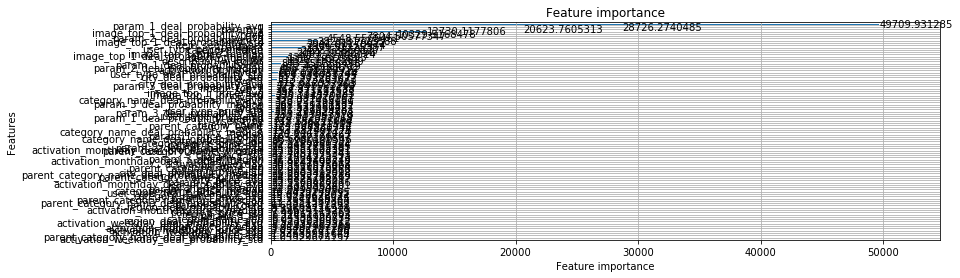

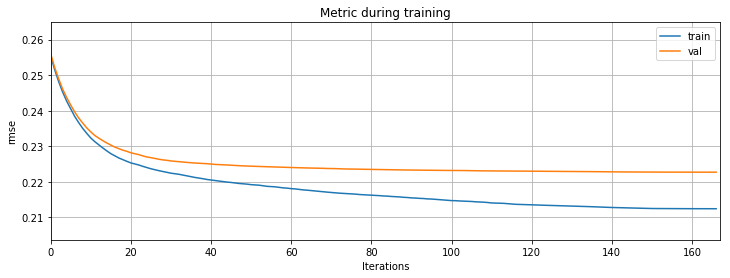

In [49]:
params['learning_rate']=0.08
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.227317 + 0.000206875
[40]	cv_agg's rmse: 0.224717 + 0.000254132
[60]	cv_agg's rmse: 0.224131 + 0.000269108
[80]	cv_agg's rmse: 0.223628 + 0.000274746
[100]	cv_agg's rmse: 0.223305 + 0.000288053
[120]	cv_agg's rmse: 0.223079 + 0.000285726
[140]	cv_agg's rmse: 0.223048 + 0.000278455
[160]	cv_agg's rmse: 0.223048 + 0.000278455
Best Iteration: 140
[20]	train's rmse: 0.223941	val's rmse: 0.22725
[40]	train's rmse: 0.219375	val's rmse: 0.224574
[60]	train's rmse: 0.217029	val's rmse: 0.223823
[80]	train's rmse: 0.215001	val's rmse: 0.223377
[100]	train's rmse: 0.213543	val's rmse: 0.223102
[120]	train's rmse: 0.212602	val's rmse: 0.222915
[140]	train's rmse: 0.212465	val's rmse: 0.222874
Model report on trian:
Train RMSE:0.2125
Model report on test:
Test RMSE:0.2229


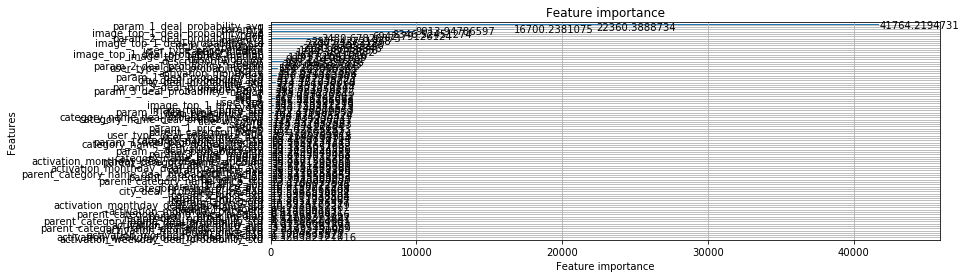

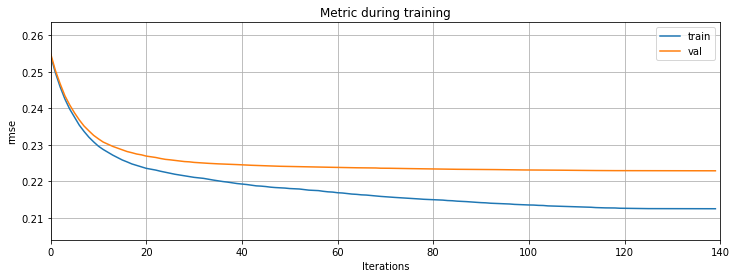

In [50]:
params['learning_rate']=0.1
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [51]:
params['learning_rate']=0.01
params['n_estimators']=1176

# 3 Final model

In [52]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.58,
 'learning_rate': 0.01,
 'max_bin': 168,
 'max_depth': 11,
 'min_child_samples': 30,
 'min_child_weight': 5,
 'min_split_gain': 0.2,
 'n_estimators': 1176,
 'n_jobs': -1,
 'num_leaves': 170,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0,
 'reg_lambda': 0.001,
 'subsample': 1.0,
 'subsample_freq': 1}

In [53]:
lgbr_opt=lgb.LGBMRegressor(**params)

In [54]:
lgbr_opt.fit(train_X,train_y,feature_name=list(train_X.columns),categorical_feature=cat_vars)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.58, learning_rate=0.01,
       max_bin=168, max_depth=11, min_child_samples=30, min_child_weight=5,
       min_split_gain=0.2, n_estimators=1176, n_jobs=-1, num_leaves=170,
       objective='regression', random_state=9, reg_alpha=0,
       reg_lambda=0.001, silent=True, subsample=1.0,
       subsample_for_bin=50000, subsample_freq=1)

In [55]:
pred_test=lgbr_opt.predict(test_X)

In [56]:
pred_test[pred_test > 1] = 1
pred_test[pred_test < 0] = 0
sub_df = pd.DataFrame({"item_id": test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv(data_dirs['pred_result'], index=False)

In [57]:
sub_df.head()

,item_id,deal_probability
0,6544e41a8817,0.042734
1,65b9484d670f,0.142267
2,8bab230b2ecd,0.173828
3,8e348601fefc,0.099151
4,8bd2fe400b89,0.239459


In [58]:
public_score=0.2282

### 保存模型

In [59]:
joblib.dump(lgbr_opt,data_dirs['model_path'])

['/home/yw/study/Competition/Avito-Demand-Prediction-Challenge/data/model_data/20180504_05LightGBM_addAggFeatures.pkl']

In [62]:
opt_feat_imp=pd.Series(lgbr_opt.feature_importances_,index=train_X.columns).sort_values(ascending=False)

In [63]:
opt_feat_imp

city                                            47479
param_1                                         26364
param_2                                         13342
price                                           11972
param_3                                         10925
category_name                                    8445
activation_monthday                              7624
item_seq_number                                  4996
image_top_1_deal_probability_avg                 4468
image_top_1_deal_probability_std                 4237
description_len                                  4054
image_top_1_price_median                         3864
region                                           3247
title_len                                        2945
description_w_count                              2757
svd_3                                            2690
svd_7                                            2513
svd_1                                            2352
image_top_1                 